In [1]:
# Cell 1 – Imports & paths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

ROOT      = Path("..").resolve()                   # repo root (one level up)
ARTF      = ROOT / "artifacts" / "forecasts"
ARTR      = ROOT / "artifacts" / "residuals"
FIG_DIR   = ROOT / "reports" / "plots" / "classical"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# helper: quick metrics
def metrics(y_true, y_pred):
    err = y_true - y_pred
    return {
        "MAE":  np.mean(np.abs(err)),
        "RMSE": np.sqrt(np.mean(err**2)),
        "MAPE": np.mean(np.abs(err / y_true)) * 100
    }


In [2]:
# Cell 2 – Load forecasts / truth & compute metrics
truth = pd.read_parquet("../data/processed/nasdaq_features.parquet")["log_ret"]
truth_test = truth.loc["2024-01-01":]

fc_arima  = pd.read_csv(ARTF/"arima_test.csv",  index_col=0, parse_dates=True).squeeze()
fc_arimax = pd.read_csv(ARTF/"arimax_test.csv", index_col=0, parse_dates=True).squeeze()
fc_sarima = pd.read_csv(ARTF/"sarima_test.csv", index_col=0, parse_dates=True).squeeze()

metrics_df = pd.DataFrame({
    "ARIMA" : metrics(truth_test.loc[fc_arima.index],  fc_arima),
    "ARIMAX": metrics(truth_test.loc[fc_arimax.index], fc_arimax),
    "SARIMA": metrics(truth_test.loc[fc_sarima.index], fc_sarima)
}).T.round(6)

display(metrics_df)

# save
METRIC_OUT = ROOT / "artifacts" / "metrics"
METRIC_OUT.mkdir(exist_ok=True, parents=True)
metrics_df.to_csv(METRIC_OUT / "classical_metrics.csv")


,MAE,RMSE,MAPE
ARIMA,0.008195,0.011585,inf
ARIMAX,0.000838,0.000866,inf
SARIMA,0.008181,0.011559,inf


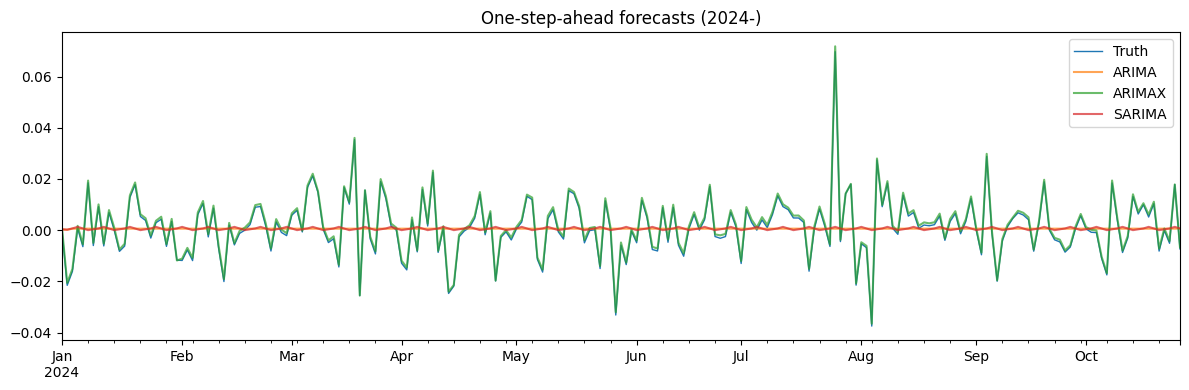

In [3]:
# Cell 3 – Forecast vs. truth
plt.figure(figsize=(12,4))
truth_test.plot(label="Truth", lw=1)
fc_arima.plot(label="ARIMA",  alpha=.7)
fc_arimax.plot(label="ARIMAX", alpha=.7)
fc_sarima.plot(label="SARIMA", alpha=.7)
plt.title("One-step-ahead forecasts (2024-)")
plt.legend()
plt.tight_layout()

plt.savefig(FIG_DIR/"forecast_overlay.png", dpi=300)
plt.show()


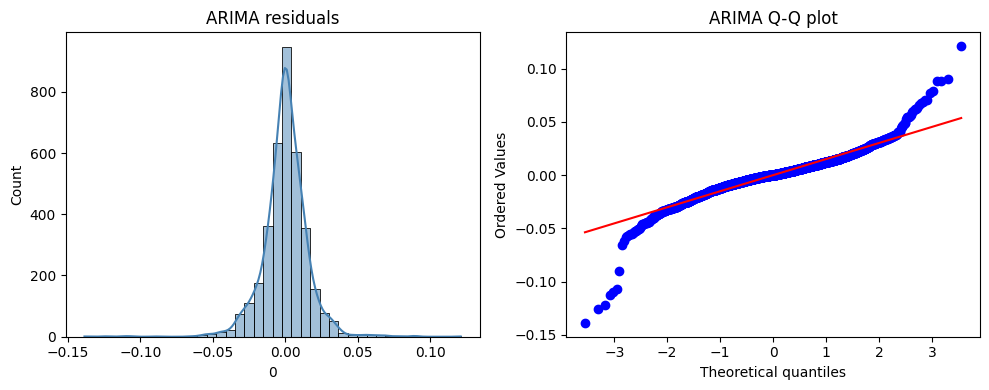

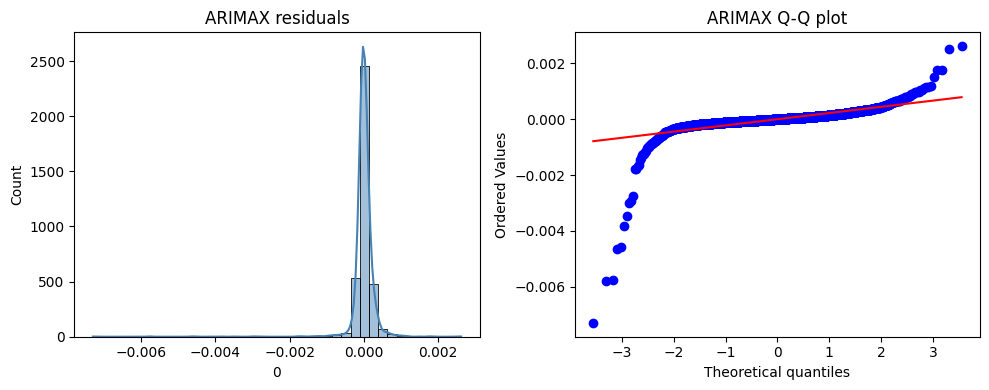

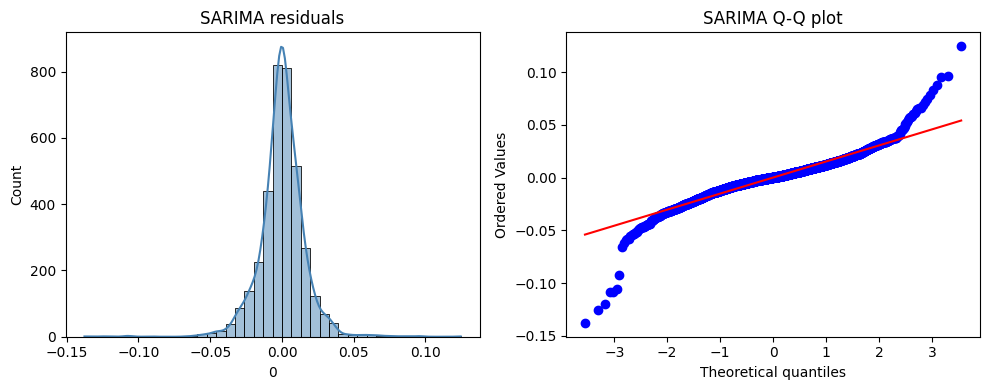

In [4]:
# Cell 4 – Residual diagnostics
res_files = {
    "ARIMA" : "arima_residuals.csv",
    "ARIMAX": "arimax_residuals.csv",
    "SARIMA": "sarima_residuals.csv"
}
for name, fn in res_files.items():
    res = pd.read_csv(ARTR/fn, index_col=0, parse_dates=True).squeeze()
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    sns.histplot(res, kde=True, ax=ax[0], bins=40, color="steelblue")
    ax[0].set_title(f"{name} residuals")
    
    stats.probplot(res, dist="norm", plot=ax[1])
    ax[1].set_title(f"{name} Q-Q plot")
    
    fig.tight_layout()
    fig.savefig(FIG_DIR/f"{name.lower()}_residuals.png", dpi=300)
    plt.show()


,LB p-value
ARIMA,0.247191
ARIMAX,0.000002
SARIMA,0.004457


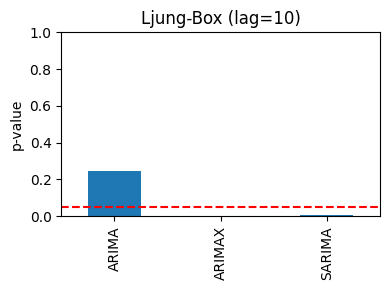

In [5]:
# Cell 5 – Ljung-Box p-values
lb_pvals = {}
for name, fn in res_files.items():
    res = pd.read_csv(ARTR/fn, index_col=0, parse_dates=True).squeeze()
    lb = acorr_ljungbox(res, lags=[10], return_df=True)
    lb_pvals[name] = lb["lb_pvalue"].iloc[0]

lb_df = pd.Series(lb_pvals, name="LB p-value").to_frame()
display(lb_df)

# bar plot
lb_df.plot(kind="bar", legend=False, figsize=(4,3), ylabel="p-value", ylim=(0,1))
plt.axhline(0.05, ls="--", color="red")
plt.title("Ljung-Box (lag=10)")
plt.tight_layout()

plt.savefig(FIG_DIR/"ljungbox_pvalues.png", dpi=300)
plt.show()


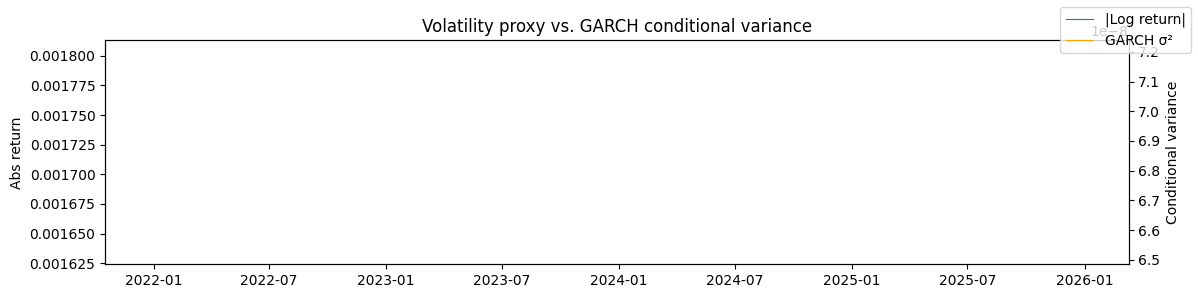

In [11]:
# Cell 6 – GARCH conditional variance vs. |returns|
var_path = ARTF / "garch_variance_scaled.csv"

# Robust load: works whether the file has a header or not
try:
    var = pd.read_csv(var_path, index_col=0, parse_dates=True).squeeze("columns")
except ValueError:
    # No header → read again with header=None, take first column after index
    var = pd.read_csv(var_path, header=None, index_col=0, parse_dates=True).iloc[:, 0]

# If the result is a scalar (single forecast), plotting isn’t meaningful
if np.isscalar(var):
    print("Variance file contains a single value; skipping variance plot.")
else:
    abs_ret = truth.loc[var.index].abs()

    fig, ax1 = plt.subplots(figsize=(12,3))
    ax1.plot(abs_ret, label="|Log return|", lw=0.8)
    ax1.set_ylabel("Abs return")

    ax2 = ax1.twinx()
    ax2.plot(var, color="orange", label="GARCH σ²", lw=0.8)
    ax2.set_ylabel("Conditional variance")

    fig.legend(loc="upper right")
    plt.title("Volatility proxy vs. GARCH conditional variance")
    plt.tight_layout()

    plt.savefig(FIG_DIR / "garch_variance_vs_absret.png", dpi=300)
    plt.show()



In [9]:
# Cell 7 – Pretty table at the end
import tabulate
print(tabulate.tabulate(metrics_df, headers="keys", floatfmt=".6f", tablefmt="github"))


|        |      MAE |     RMSE |   MAPE |
|--------|----------|----------|--------|
| ARIMA  | 0.008195 | 0.011585 |    inf |
| ARIMAX | 0.000838 | 0.000866 |    inf |
| SARIMA | 0.008181 | 0.011559 |    inf |


In [12]:
# Cell 8 – Wrap-up
print("Classical models evaluation complete.  Plots saved to:", FIG_DIR)


Classical models evaluation complete.  Plots saved to: /teamspace/studios/this_studio/TS/AI_TimeSeries_Forecasting/reports/plots/classical
